## GAN Notebook

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [70]:
torch.manual_seed(111)

In [71]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) #torch.rand generates (x) number of random numbers between 0-1
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [72]:
print(train_set[0:5])

[(tensor([ 4.4960, -0.9767]), tensor(0.)), (tensor([ 5.7428, -0.5145]), tensor(0.)), (tensor([1.7710, 0.9800]), tensor(0.)), (tensor([1.6217, 0.9987]), tensor(0.)), (tensor([ 3.9654, -0.7337]), tensor(0.))]


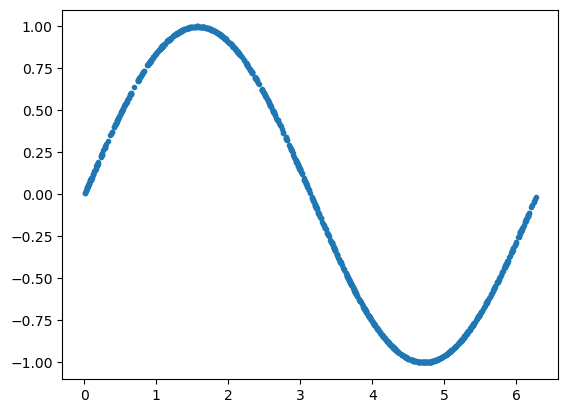

In [73]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [74]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### GAN Discriminator and Generator Classes

In [75]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),        # 1/(1+e^(-x))    
        )
        # self.nn_layers = nn.ModuleList()

        
    def forward(self, x):
        output = self.model(x)
        return output

In [76]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [77]:
discriminator = Discriminator()
generator = Generator()

### Training Parameters

In [78]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [79]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

### Training Algorithm

In [80]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        # if epoch % 10 == 0 and n == batch_size - 1:
        #     print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        #     print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308742463588715
Epoch: 0 Loss G.: 1.7989580631256104
Epoch: 10 Loss D.: 0.6099681258201599
Epoch: 10 Loss G.: 0.9077385663986206
Epoch: 20 Loss D.: 0.620063066482544
Epoch: 20 Loss G.: 0.9532097578048706
Epoch: 30 Loss D.: 0.6275926232337952
Epoch: 30 Loss G.: 0.9946499466896057
Epoch: 40 Loss D.: 0.6445602774620056
Epoch: 40 Loss G.: 1.0271791219711304
Epoch: 50 Loss D.: 0.6554452180862427
Epoch: 50 Loss G.: 0.8108565211296082
Epoch: 60 Loss D.: 0.6525333523750305
Epoch: 60 Loss G.: 0.8348451852798462
Epoch: 70 Loss D.: 0.6699002385139465
Epoch: 70 Loss G.: 0.804533064365387
Epoch: 80 Loss D.: 0.6620083451271057
Epoch: 80 Loss G.: 0.6995521187782288
Epoch: 90 Loss D.: 0.6495426893234253
Epoch: 90 Loss G.: 0.8708884716033936
Epoch: 100 Loss D.: 0.6215328574180603
Epoch: 100 Loss G.: 0.8679273724555969
Epoch: 110 Loss D.: 0.6566540002822876
Epoch: 110 Loss G.: 0.816747784614563
Epoch: 120 Loss D.: 0.6921386122703552
Epoch: 120 Loss G.: 0.9565378427505493
Epoch: 130

## Checking Results

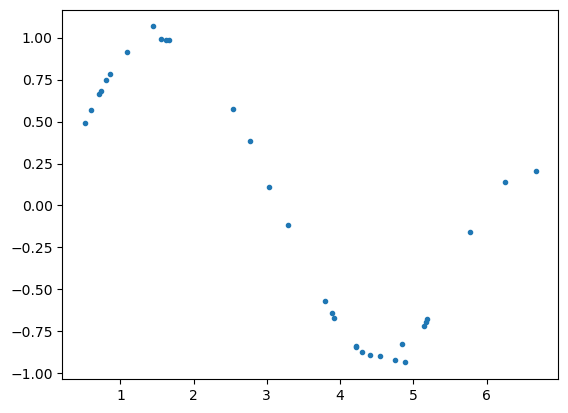

In [90]:
plt.plot(generated_samples[:, 0].detach().numpy(), generated_samples[:, 1].detach().numpy(), ".")

In [91]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

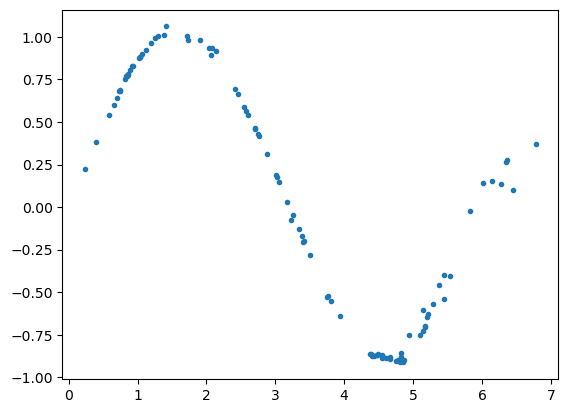

In [92]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

# Using GANs to generate handwritten digits

In [94]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [95]:
torch.manual_seed(111)

In [96]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [97]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [98]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

14.9%

100.0%


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


100.0%


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw




100.0%
100.0%

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [99]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Example Handwritten Digits

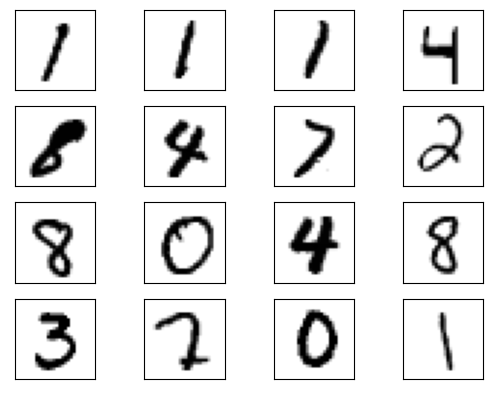

In [100]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Disciminator and Generator Classes

In [101]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [102]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [103]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

### Model Parameters

In [104]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

### Training Algorithm

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

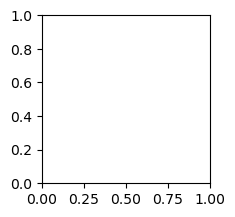

In [107]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([])